##  Adaptation for Nasukawa and Yi, 2003
    Sentiment Analysis: Capturing Favorability Using Natural Language Processing

Source:

Tetsuya Nasukawa and Jeonghee Yi. 2003. Sentiment analysis: capturing favorability using natural language processing. In Proceedings of the 2nd international conference on Knowledge capture (K-CAP '03). ACM, New York, NY, USA, 70-77. DOI=http://dx.doi.org/10.1145/945645.945658

    The essential issues in sentiment analysis are to identify
    how sentiments are expressed in texts and whether the
    expressions indicate positive (favorable) or negative
    (unfavorable) opinions toward the subject. In order to
    improve the accuracy of the sentiment analysis, it is
    important to properly identify the semantic relationships
    between the sentiment expressions and the subject. By
    applying semantic analysis with a syntactic parser and
    sentiment lexicon, our prototype system achieved high
    precision (75-95%, depending on the data) in finding
    sentiments within Web pages and news articles. 

In [3]:
from __future__ import unicode_literals
from __future__ import division
from __future__ import print_function

## 1. Checking how to capture verb and predicates

In [4]:
import nltk
annotation = '''
1	Esta	_	PRON	_	2	nsubj
2	é	_	VERB	_	0	ROOT
3	uma	_	DET	_	4	det
4	sentença	_	NOUN	_	2	attr
5	de	_	ADP	_	4	adpmod
6	teste	_	NOUN	_	5	adpobj
7	.	_	.	_	2	p
'''
graph = nltk.DependencyGraph(annotation)

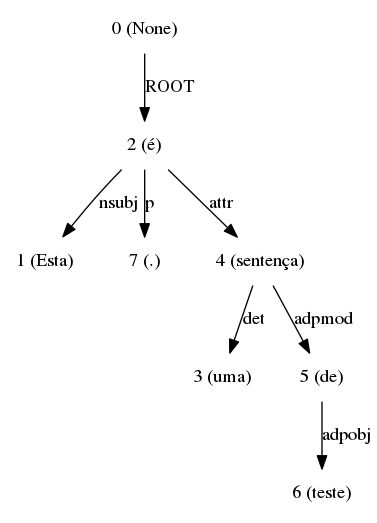

In [5]:
from IPython.display import Image
import pydot
pydot_graph = pydot.graph_from_dot_data(graph.to_dot())
Image(pydot_graph.create_png())

In [6]:
graph.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>>,
            {0: {'address': 0,
              'ctag': 'TOP',
              'deps': defaultdict(list, {'ROOT': [2]}),
              'feats': None,
              'head': None,
              'lemma': None,
              'rel': None,
              'tag': 'TOP',
              'word': None},
             1: {'address': 1,
              'ctag': 'PRON',
              'deps': defaultdict(list, {}),
              'feats': '',
              'head': 2,
              'lemma': '_',
              'rel': 'nsubj',
              'tag': 'PRON',
              'word': 'Esta'},
             2: {'address': 2,
              'ctag': 'VERB',
              'deps': defaultdict(list, {'attr': [4], 'nsubj': [1], 'p': [7]}),
              'feats': '',
              'head': 0,
              'lemma': '_',
              'rel': 'ROOT',
              'tag': 'VERB',
              'word': 'é'},
             3: {'address': 3,
      

In [7]:
print(graph.root['deps']['nsubj'])
print(graph.root['deps']['attr'])

[1]
[4]


In [9]:
print(get_subj(graph))
print(get_verb(graph))
print(get_attr(graph))

Esta
é
uma sentença de teste


In [19]:
def get_nasukawa_templates(graph):
    
    templates = []
    
    # return templates empty in case of null graph
    if graph.root is None:
        return templates
    
    # get the verb nodes
    for node_index in graph.nodes:
        if graph.nodes[node_index]['ctag'] == 'VERB':
            template = dict()
            template['verb'] = dict()
            template['verb']['address'] = node_index
            template['verb']['tag'] = graph.nodes[node_index]['ctag']            
            template['verb']['rel'] = graph.nodes[node_index]['rel']
            template['verb']['obj'] = graph.nodes[node_index]['feats']
            template['verb']['form'] = graph.nodes[node_index]['word']
            templates.append(template)
    
    # get all nodes connected directly with the verbs (with the verb as head)
    for template in templates:        
        verb_index = template['verb']['address']
        for node_index in graph.nodes:
            if (graph.nodes[node_index]['head'] == verb_index and
                # graph.nodes[node_index]['rel'] != 'p' and
                # graph.nodes[node_index]['rel'] != 'ROOT' and
                graph.nodes[node_index]['feats'] != 'O'):
                    template['obj'] = dict()
                    template['obj']['address'] = node_index
                    template['obj']['tag'] = graph.nodes[node_index]['ctag']
                    template['obj']['rel'] = graph.nodes[node_index]['rel']
                    template['obj']['obj'] = graph.nodes[node_index]['feats']
                    template['obj']['form'] = graph.nodes[node_index]['word']
            break
                                        
    return [template for template in templates if 'obj' in template]




pprint(get_nasukawa_templates(graph))

[]


## 1. Capturing patterns (obj, verb, subj) in the trainset

In [20]:
from lxml import etree
parser = etree.XMLParser(remove_blank_text=True)
trainset = etree.parse('../corpus/ReLiUniversalDependencies_train.xml', parser)
testset = etree.parse('../corpus/ReLiUniversalDependencies_test.xml', parser)

bookaddicted.net


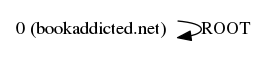

A o ver o título de o livro, sinceramente, eu não tive muita curiosidade em ler.


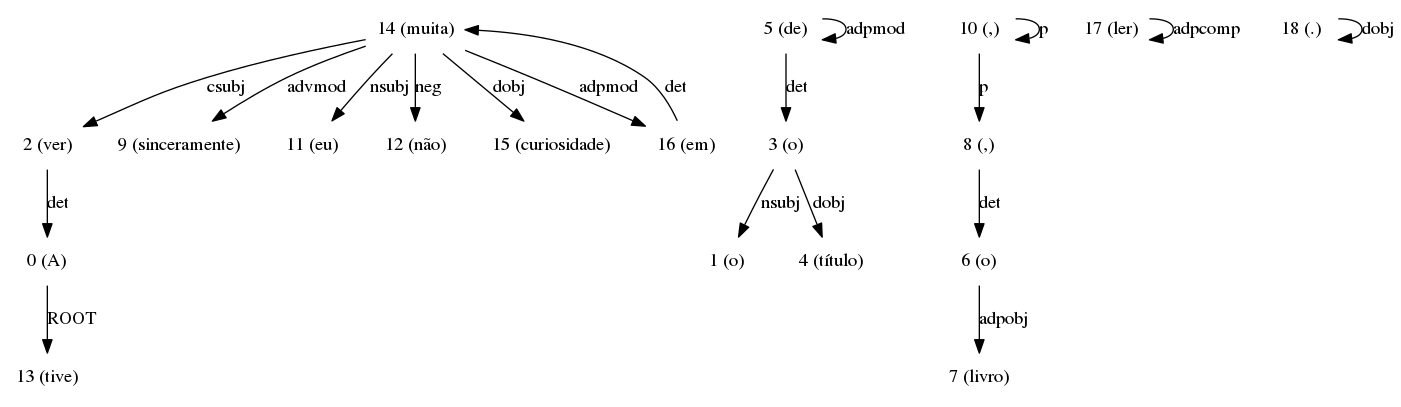

Depois, veio a morte de J. D. Salinger, veio todo o "boom" em torno de sua obra, principalmente em torno de "O Apanhador em o Campo de Centeio" e aí bateu uma certa vontade de conhecer a história.
13 [label="13 (")"]
   ^
Expected "}" (at char 599), (line:30, col:4)
Troquei o livro por o Skoob e ficou guardado um bom tempo, até que resolvi dar uma chance para o livro.


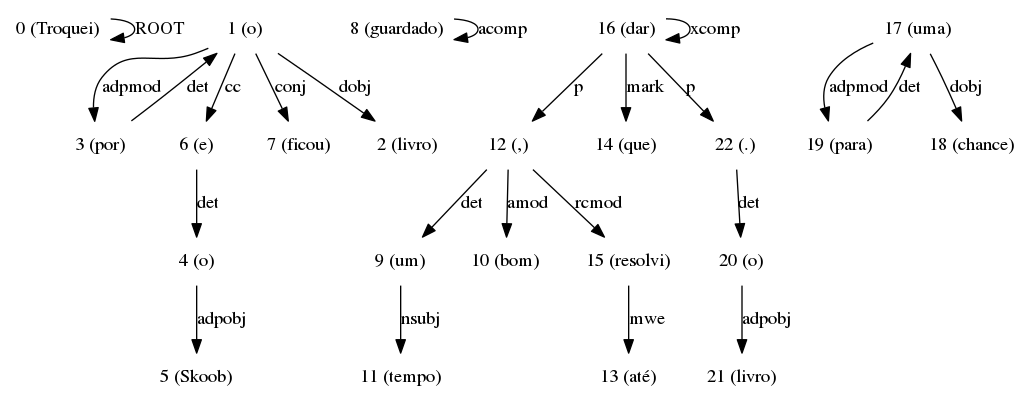

De verdade?


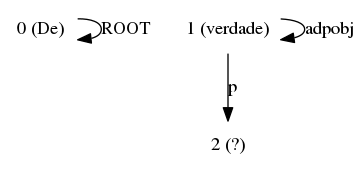

Não me arrependi.


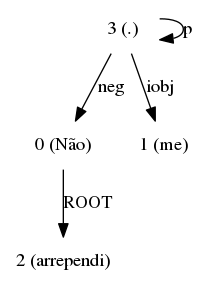

Este romance foi originalmente publicado em formato de revista, entre 1945-1946 e posteriormente editado em o formado de livro em 1951.


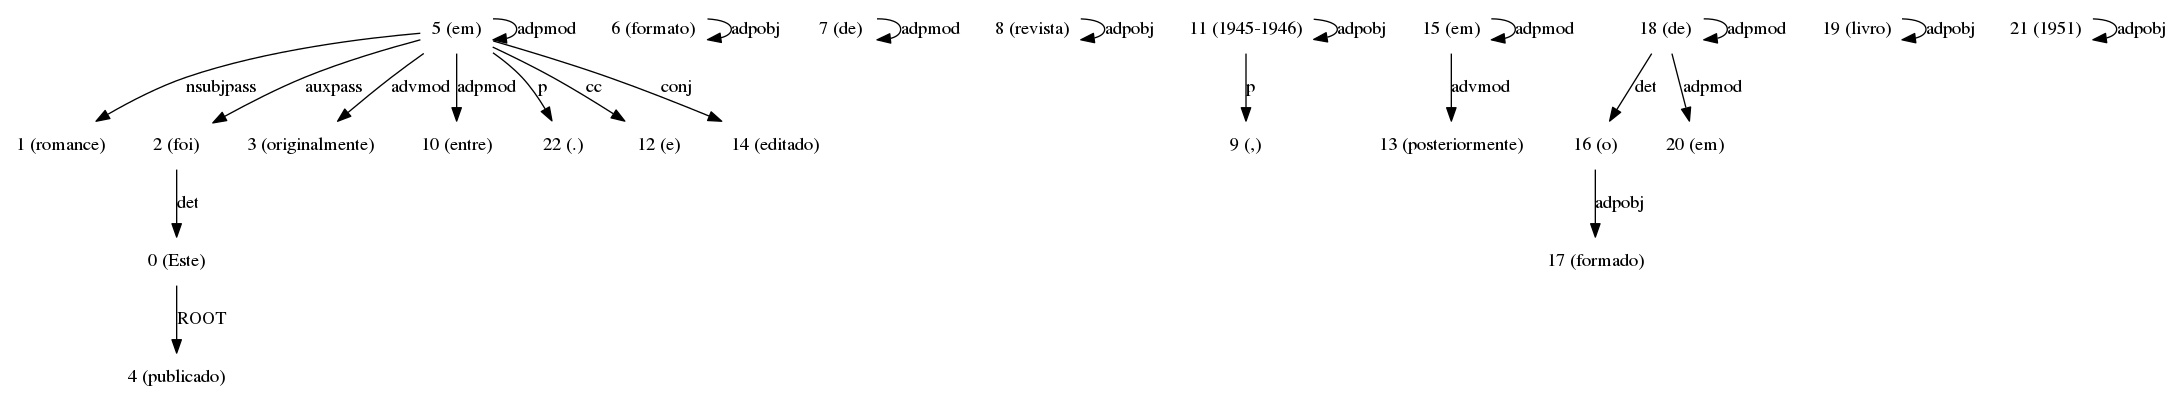

Este ano, a obra completa 60 anos, e até hoje é um de os livros mais lidos de o mundo inteiro.


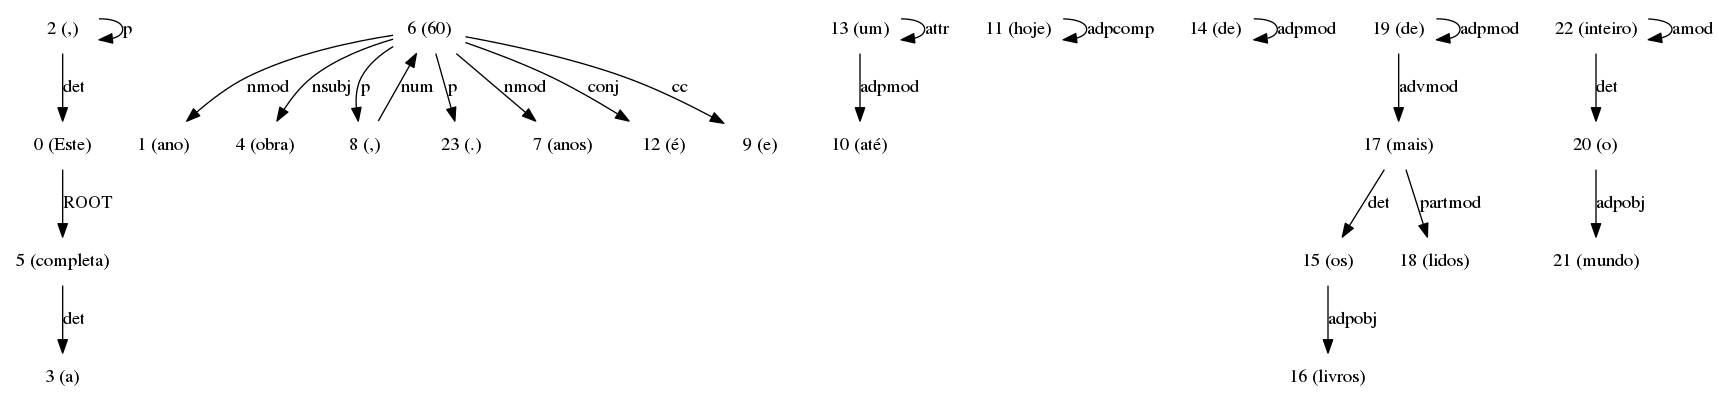

Não é pra menos.


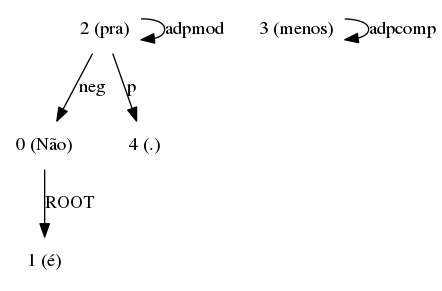

A história, mesmo escrita há muito tempo atrás, é atual e se desenrola fácil.


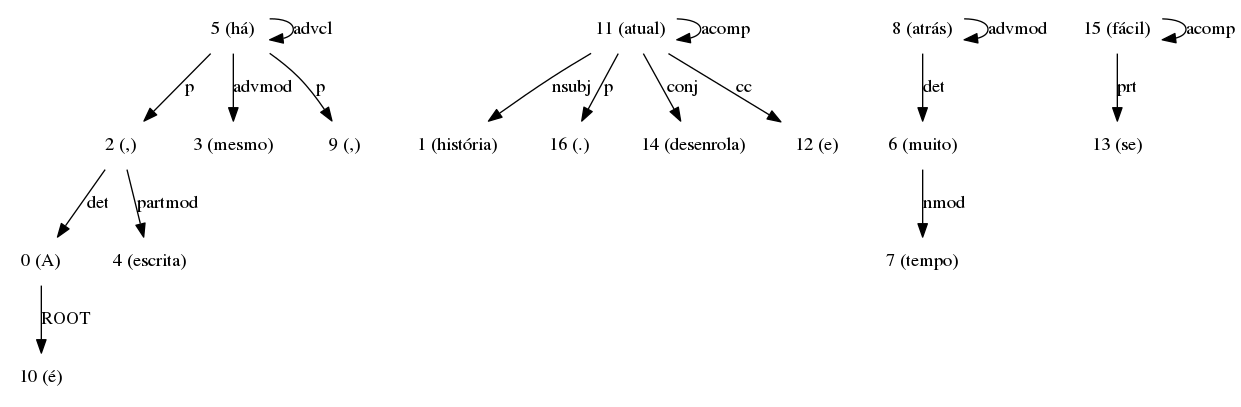

In [21]:
from IPython.display import display
from pprint import pprint

for sentence_node in list(trainset.iter('sentence'))[:10]:
    # discover the head
    grid = ''
    print(sentence_node.xpath('string(text/text())'))        
        
    word_nodes = list(sentence_node.iter('word'))
    for word_node in word_nodes:
        # 10 cells representation: line_index, word, lemma, ctag, tag, feats, head, rel, _, _
        grid += '\t'.join( [word_node.get('id'),
                            word_node.get('form'),
                            word_node.get('base'),
                            word_node.get('postag'),
                            word_node.get('postag'),
                            word_node.get('obj'),                            
                            word_node.get('head'),
                            word_node.get('deprel'),'_','_']
                          ) + '\n'
    
    graph = nltk.DependencyGraph(grid)
    if graph.root is not None:
        pydot_graph = pydot.graph_from_dot_data(graph.to_dot())
        if pydot_graph:
            display(Image(pydot_graph.create_png()))    
    

In [22]:
# split claused containing the verb
templates = []
for sentence_node in list(trainset.iter('sentence')):
    grid = ''
    for word_node in sentence_node.iter('word'):
        # 10 cells representation: line_index, word, lemma, ctag, tag, feats, head, rel, _, _
        grid += '\t'.join( [word_node.get('id'),
                            word_node.get('form'),
                            word_node.get('base'),
                            word_node.get('postag'),
                            word_node.get('postag'),
                            word_node.get('obj'),                            
                            word_node.get('head'),
                            word_node.get('deprel'),'_','_']
                          ) + '\n'
    
    graph = nltk.DependencyGraph(grid)
    templates += get_nasukawa_templates(graph)                    
        
patterns = []
for template in templates:
    verb = template['verb']['form'].lower()
    obj = template['obj']['form'].lower()    
    patterns.append((verb, obj))
    
pprint(patterns)

[('são', 'algumas'),
 ('é', 'holden'),
 ('é', 'kate'),
 ('ficar', 'ficar'),
 ('escrita', 'escrita'),
 ('trama', 'trama'),
 ('virar', 'twilight'),
 ('romance', 'romance'),
 ('desmedida', 'a'),
 ('é', 'edward'),
 ('escrita', 'escrita'),
 ('leitura', 'leitura')]


In [ ]:

def get_connected_nodes(head, nodes):
    node_list = [head]
    for node_index in nodes:
        if nodes[node_index]['head'] == head:
            node_list.append(node_index)
            node_list += get_connected_nodes(node_index)
    return sorted(set(node_list))

def get_verb(graph):
    return graph.root['word']

def get_subj(graph):
    if 'nsubj' in graph.root['deps'] and graph.root['deps']['nsubj'] is not None:
        return [node_index for node_index in get_connected_nodes(graph.root['deps']['nsubj'][0], graph.nodes)])
    else:
        return []
    
def get_attr(graph):
    if 'attr' in graph.root['deps']:
        return ' '.join([nodes[node_index]['word'] for node_index in get_connected_nodes(graph.root['deps']['attr'][0])])
    else:
        return ''

In [44]:


def get_nasukawa_simple_templates(graph):
    
    # keep the position for the obj
    position = 0
    
    # return templates empty in case of null graph
    if graph.root is None:
        return templates
    
    has_obj = False
    for node_index in graph.nodes:
        if graph.nodes[node_index]['feats'] != 'O':
            has_obj = True
    
    if has_obj:
        try:

            subj_graph = get_subj(graph)
            print (subj_graph)
            subj = ' '.join([graph.nodes[i]['word'] for i in subj_graph])
            if len([i for i in subj_graph if graph.nodes[i]['feats'] != 'O' > 0]):
                 position = 1


            verb_graph = get_verb(graph)
            verb = ' '.join([graph.nodes[i]['word'] for i in verb_graph])
            if len([i for i in verb_graph if graph.nodes[i]['feats'] != 'O' > 0]):
                 position = 2

            attr_graph = get_attr(graph)
            subj = ' '.join([graph.nodes[i]['word'] for i in attr_graph])
            if len([i for i in attr_graph if graph.nodes[i]['feats'] != 'O' > 0]):
                 position = 3

            return [( get_subj(graph), get_verb(graph), get_attr(graph), position)]
        except:
            return []
    return []

In [45]:
# split claused containing the verb
templates = []
for sentence_node in list(trainset.iter('sentence')):
    grid = ''
    for word_node in sentence_node.iter('word'):
        # 10 cells representation: line_index, word, lemma, ctag, tag, feats, head, rel, _, _
        grid += '\t'.join( [word_node.get('id'),
                            word_node.get('form'),
                            word_node.get('base'),
                            word_node.get('postag'),
                            word_node.get('postag'),
                            word_node.get('obj'),                            
                            word_node.get('head'),
                            word_node.get('deprel'),'_','_']
                          ) + '\n'
    
    graph = nltk.DependencyGraph(grid)
    templates += get_nasukawa_simple_templates(graph)                    
        
pprint(templates)
















































































































































Esta é uma sentença de teste .






















































































































































































































































































































































































































































































































































































































Esta é uma sentença de teste .







































































































































































































In [14]:
test_gold = list()


for sentence_node in testset.iter('sentence'):    
    sentence_opinions = []
    for opinion_node in sentence_node.iter('Opinion'):
        target = opinion_node.get('target')
        start = int(opinion_node.get('from'))
        end = int(opinion_node.get('to'))
        # evaluation explicit says to discart NULL values
        if target != 'NULL':
            sentence_opinions.append((target, start, end))
    test_gold.append(sentence_opinions)

In [15]:
prediction = list()
for sentence_node in testset.iter('sentence'):            
        
    for word_node in sentence_node.iter('word'):
        verbs = []
        if word_node.get('postag') == 'VERB':
            verbs.append((word_node.get('form').lower, word_node.get('id')))
        
    text_opinions = []
    for word_node in word_nodes:
        for token, token_id in verbs:
            if (word_node.get('head') == token_id and 
                word_node.get('id') != token_id and
                word_node.get('deprel') != 'p' and
                word_node.get('deprel') != 'ROOT'):
                              
                # check with nasukawa learnt patterns
                for verb, obj in patterns:
                    if verb == token and obj == word_node.get('form').lower():
                        text_opinions.append( (word_node.get('form'), word_node.get('from'), word_node.get('to')) )                
                                                         
    prediction.append(text_opinions)

In [16]:
import ipy_table
data = [['Gold Standard', 'Predicted', 'Sentence']]
for index, (gold, pred) in enumerate(list(zip(test_gold, prediction))[:100]):
    sentence = list(testset.iter('sentence'))[index].xpath('./text/text()')[0]
    data.append([gold, pred, sentence])

ipy_table.make_table(data)
ipy_table.set_global_style(wrap=True)
ipy_table.apply_theme('basic')

Gold Standard,Predicted,Sentence
[],[],Está provado: Pode existir um livro bom sem uma história boa
[],[],"""Se querem mesmo ouvir o que aconteceu, a primeira coisa que vão querer saber é onde eu nasci, como passei a porcaria de a minha infância (...) e toda essa lenga-lenga...""."
"[('O Apanhador em o Campo de Centeio', 14, 47)]",[],"Assim começa ""O Apanhador em o Campo de Centeio"", um verdadeiro clássico de a literatura mundial."
[],[],"E essas três primeiras linhas são suficientes para termos um norte bem contextualizado de tudo quanto encontraremos a o longo de as 207 páginas que a versão brasileira, publicada por a EDITORA DE O AUTOR, trará."
[],[],"Em ""O Apanhador"", o leitor é convidado a vestir a pele de um adolescente revoltado, Holden Caulfield, que, em o auge de seus 17 anos, conta ""esse negócio doido que aconteceu em o último Natal""."
[],[],A verdade é que não tem negócio doido coisa nenhuma.
[],[],"A história em si não tem nada de mirabolante, se é que a história despretensiosa de um adolescente rebelde que bombou em quase todas as matérias (exceto Inglês/literatura, e é em este ponto que identifico a primeira marquinha de o alter ego de o autor, J. D. Salinger), que tinha um olhar crítico para tudo a o seu redor, e ainda parecia bem perdido em a vida, soaria mirabolante ou diferente de o cotidiano de boa parte de os adolescentes de os dias de hoje."
[],[],"Mas vamos devagar com o andar de a carruagem, chegaremos lá."
[],[],Há de se ressaltar que este clássico não é tão fácil de ser encontrado.
[],[],"Antes de achar o meu exemplar, procurei em várias livrarias, que diziam ser necessário fazer uma encomenda, com todo aquele papo de ""tantos dias úteis"", ""ligamos para você quando chegar"", etc e tal."


### Aspect-extraction Evaluation methodology

Pontiki, M., Galanis, D., Papageorgiou, H., Manandhar, S., & Androutsopoulos, I. (2015, June). Semeval-2015 task 12: Aspect based sentiment analysis. In Proceedings of the 9th International Workshop on Semantic Evaluation (SemEval 2015), Association for Computational Linguistics, Denver, Colorado (pp. 486-495).

http://www.anthology.aclweb.org/S/S15/S15-2082.pdf

From 4.1 Evaluation Measures, page 491:

Slot 2: F-1 scores are calculated by comparing
the targets that a system returned (for all the sentences)
to the corresponding gold targets (using
micro-averaging). The targets are extracted using
their starting and ending offsets. The calculation
for each sentence considers only distinct targets
and discards NULL targets, since they do not correspond
to explicit mentions

In [17]:
# Micro-averaged Precision
correct = 0
total = 0
for index in range(len(list(testset.iter('sentence')))):
    correct += len([x for x in test_gold[index] if x in prediction[index]])
    total += len(prediction[index])

precision = 100 * correct / total
print('Precision: {:.2f}%'.format(precision))

ZeroDivisionError: division by zero

In [18]:
# Micro-averaged Recall
correct = 0
total = 0
for index in range(len(list(testset.iter('sentence')))):
    correct += len([x for x in test_gold[index] if x in prediction[index]])
    total += len(test_gold[index])

recall = 100* correct / total
print('Recall: {:.2f}%'.format(recall))

Recall: 0.00%


In [14]:
print('F-measure: {:.2f}%'.format((2 * precision * recall) / (precision + recall)))

F-measure: 13.13%


In [16]:
# Save the prediction (Optional)
import re
for sentence_node in testset.iter('sentence'):
    sentence_opinions = []
    opinions_node = sentence_node.xpath('./Opinions')
    if opinions_node:
        opinions_node = opinions_node[0]
    else:
        opinions_node = etree.SubElement(sentence_node, 'Opinions')
        
    for opinion_node in sentence_node.xpath('./Opinions/Opinion'):
        opinions_node.remove(opinion_node)
    
    text = sentence_node.xpath('./text/text()')[0]
    for m in re.finditer(targets_pattern, text):
        opinion_node = etree.SubElement(opinions_node, 'Opinion')
        opinion_node.set('target', m.group())
        opinion_node.set('from', str(m.start()))
        opinion_node.set('to', str(m.end()))
        
etree.ElementTree(testset.getroot()).write('../corpus/pred.xml',encoding='utf8', xml_declaration=True, pretty_print=True)

## 2. All aspects in trainset removing stopwords

In [23]:
from collections import Counter
from nltk.corpus import stopwords
# build the targets
stopwords = stopwords.words('portuguese') + ['esse', 'ser', 'ele', 'isso']
targets = Counter([opinion_node.get('target').lower()
                    for opinion_node in trainset.iter('Opinion')
                    if opinion_node.get('target') != 'NULL' and
                       opinion_node.get('target').lower() not in stopwords
                   ])

# print the targets
import ipy_table
data = [['freq', '%freq', 'target']]
for target, freq in targets.most_common(20):
    ratio = freq / sum(targets.values()) *100
    data.append([freq, '{:.1f}%'.format(ratio), target])

ipy_table.make_table(data)
ipy_table.apply_theme('basic')

freq,%freq,target
681,33.9%,livro
150,7.5%,história
88,4.4%,leitura
59,2.9%,personagens
47,2.3%,crepúsculo
44,2.2%,narrativa
42,2.1%,romance
39,1.9%,obra
35,1.7%,final
35,1.7%,1984


In [49]:
import re

# function to evaluate targets in testset and return precision, recall and f-measure
def evaluate(targets):

    # Build a regex to match the targets in the text
    targets_list = sorted(list(targets))
    targets_list.sort(key=len, reverse=True)
    targets_pattern = r'\b(' + '|'.join([re.escape(t) for t in targets_list]) + r')\b'

    test_gold = list()
    prediction = list()

    for sentence_node in testset.iter('sentence'):    
        sentence_opinions = []
        for opinion_node in sentence_node.iter('Opinion'):
            target = opinion_node.get('target')
            start = int(opinion_node.get('from'))
            end = int(opinion_node.get('to'))
            # evaluation explicit says to discart NULL values
            if target != 'NULL':
                sentence_opinions.append((target, start, end))
        test_gold.append(sentence_opinions)

        text = sentence_node.xpath('./text/text()')[0]
        text_opinions = []

        for m in re.finditer(targets_pattern, text, flags=re.I):
            text_opinions.append( (m.group(), m.start(), m.end()) )
        prediction.append(text_opinions)
        
    # Micro-averaged Precision
    correct = 0
    total = 0
    for index in range(len(list(testset.iter('sentence')))):
        correct += len([x for x in test_gold[index] if x in prediction[index]])
        total += len(prediction[index])

    precision = 100 * correct / total    

    # Micro-averaged Recall
    correct = 0
    total = 0
    for index in range(len(list(testset.iter('sentence')))):
        correct += len([x for x in test_gold[index] if x in prediction[index]])
        total += len(test_gold[index])

    recall = 100* correct / total
    
    # F-measure
    if precision + recall != 0:
        fmeasure = (2 * precision * recall) / (precision + recall)
    else:
        fmeasure = 0
    
    return (precision, recall, fmeasure)
    
  

In [47]:
precision, recall, fmeasure = evaluate(targets)
print('Precision: {:.2f}%'.format(precision))
print('Recall: {:.2f}%'.format(recall))
print('F-measure: {:.2f}%'.format(fmeasure))

Precision: 7.14%
Recall: 82.26%
F-measure: 13.13%


## 3. All aspects in trainset with a cut in frequency

In [60]:
# build the targets
targets = Counter([opinion_node.get('target').lower()
                    for opinion_node in trainset.iter('Opinion')
                    if opinion_node.get('target') != 'NULL'])

data = [['cut', 'number of targets', 'precision', 'recall', 'f-measure']]
for min_freq in range(0,11,1):
    target_list = [target for target, freq in targets.items() if freq/sum(targets.values()) >= min_freq/100]
    precision, recall, fmeasure = evaluate(target_list)
    data.append(['{:.1f}%'.format(min_freq), 
                 len(target_list),
                 '{:.2f}%'.format(precision), 
                 '{:.2f}%'.format(recall), 
                 '{:.2f}%'.format(fmeasure)])

ipy_table.make_table(data)
ipy_table.apply_theme('basic')

cut,number of targets,precision,recall,f-measure
0.0%,436,7.14%,82.26%,13.13%
1.0%,15,25.66%,64.95%,36.79%
2.0%,7,30.27%,55.51%,39.17%
3.0%,3,31.39%,45.35%,37.10%
4.0%,3,31.39%,45.35%,37.10%
5.0%,2,31.85%,41.92%,36.20%
6.0%,2,31.85%,41.92%,36.20%
7.0%,2,31.85%,41.92%,36.20%
8.0%,1,33.57%,33.62%,33.60%
9.0%,1,33.57%,33.62%,33.60%


## 3. All aspects with relative frequency
 
The token must happen % of the time annotated as aspect in the text.

In [64]:
sentences = ' '.join([node.get('form').lower() for node in testset.iter('word')])
freqlist =  Counter([node.get('target').lower() for node in testset.iter('Opinion')])

# build the targets
targets = Counter([opinion_node.get('target').lower()
                    for opinion_node in trainset.iter('Opinion')
                    if opinion_node.get('target') != 'NULL'])

data = [['cut', 'number of targets', 'precision', 'recall', 'f-measure']]
for min_freq in range(0,100,5):
    
    target_list = [target for target, freq in targets.items() if freq/max(sentences.count(' ' + target + ' '),0.00001) >= min_freq/100]
        
    precision, recall, fmeasure = evaluate(target_list)
    data.append(['{:.1f}%'.format(min_freq), 
                 len(target_list),
                 '{:.2f}%'.format(precision), 
                 '{:.2f}%'.format(recall), 
                 '{:.2f}%'.format(fmeasure)])

ipy_table.make_table(data)
ipy_table.apply_theme('basic')

cut,number of targets,precision,recall,f-measure
0.0%,436,7.14%,82.26%,13.13%
5.0%,406,16.65%,80.11%,27.57%
10.0%,390,19.03%,78.25%,30.61%
15.0%,373,21.94%,74.82%,33.93%
20.0%,367,22.74%,74.11%,34.80%
25.0%,344,25.34%,70.24%,37.24%
30.0%,340,25.71%,70.24%,37.64%
35.0%,320,26.25%,68.53%,37.96%
40.0%,318,26.57%,67.95%,38.20%
45.0%,318,26.57%,67.95%,38.20%
